<a href="https://colab.research.google.com/github/SimeonHristov99/AI_HandwrittenCharacterClassifier_Tensorflow/blob/main/src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Deep Learning with Tensorflow
=============

Assignment II - Convolutional Neural Networks
------------

Previously in `20210322-lab-1-notmnist.ipynb`, we created a pickle with formatted datasets for training, development and testing on the [notMNIST dataset](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

The goal of this assignment is make the neural network convolutional.

In [ ]:
!wget https://gist.githubusercontent.com/nktaushanov/7aa762a4e1370b5ad287e87595c6499e/raw/4e6ee948d963d4efe16a9452036c6e380d0b30db/download_notmnist.py

--2021-06-07 11:45:39--  https://gist.githubusercontent.com/nktaushanov/7aa762a4e1370b5ad287e87595c6499e/raw/4e6ee948d963d4efe16a9452036c6e380d0b30db/download_notmnist.py
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7285 (7.1K) [text/plain]
Saving to: ‘download_notmnist.py’

download_notmnist.p 100%[===================>]   7.11K  --.-KB/s    in 0s      

2021-06-07 11:45:39 (38.0 MB/s) - ‘download_notmnist.py’ saved [7285/7285]



In [ ]:
import download_notmnist
train_dataset, train_labels, test_dataset, test_labels, valid_dataset, valid_labels = download_notmnist.run()
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified ./notMNIST_small.tar.gz
Extracting data for ./notMNIST_large. This may take a while. Please wait.
['./notMNIST_large/A', './notMNIST_large/B', './notMNIST_large/C', './notMNIST_large/D', './notMNIST_large/E', './notMNIST_large/F', './notMNIST_large/G', './notMNIST_large/H', './notMNIST_large/I', './notMNIST_large/J']
Extracting data for ./notMNIST_small. This may take a while. Please wait.
['./notMNIST_small/A', './notMNIST_small/B', './notMNIST_small/C', './notMNIST_small/D', './notMNIST_small/E', './notMNIST_small/

In [ ]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

## Let's check what the training set looks like.

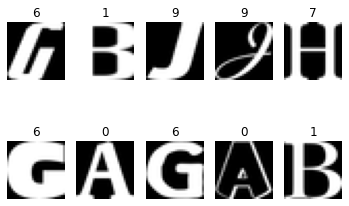

In [ ]:
import matplotlib.pyplot as plt

for i in range(10):
  plt.subplot(2, 5, i + 1)
  sample_idx = np.random.randint(train_dataset.shape[0])
  image = train_dataset[sample_idx]
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.title(train_labels[sample_idx])

plt.show()

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

In [ ]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale

def reformat(dataset, labels):
  dataset = dataset.reshape((-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels

train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)

print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 10)
Validation set (10000, 28, 28, 1) (10000, 10)
Test set (10000, 28, 28, 1) (10000, 10)


## Notes on shapes

 - 10 classes, representing letters 'A' .. 'J' .
 - 200_000 images each with width and height 28 x 28 for training.
 - 10_000 images each with width and height 28 x 28 for validating/model tuning.
 - 10_000 images each with width and height 28 x 28 for testing.

 - Each image has a depth of 1, because it's grayscale (black and white).
 - Each label is a vector with 10 coordinates - 1 for each class.

In [ ]:
def accuracy(predictions, labels):
  return (100.0 *
          np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0]
          )

In [ ]:
batch_size = 16
train_tf_dataset = tf.data.Dataset.from_tensor_slices(
    (train_dataset, train_labels)).shuffle(1000).batch(batch_size)

## Problem 1
Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

Edit the snippet bellow by changing the `model` function.

### 1.1 - Define the model
Implement the `model` function bellow. Take a look at the following TF functions:
- **tf.nn.conv2d(X,W1, strides = [1,s,s,1], padding = 'SAME'):** given an input $X$ and a group of filters $W1$, this function convolves $W1$'s filters on X. The third input ([1,f,f,1]) represents the strides for each dimension of the input (m, n_H_prev, n_W_prev, n_C_prev). You can read the full documentation [here](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)
- **tf.nn.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/nn/relu)

Define a simple network with:
 - 2 convolutional layers with 5x5 filters each using stride 2 and zero padding
 - one fully connected layer
 - return the logits (last layer)

Notes on the shapes of variables:
  - data (16, 28, 28, 1) = 16 images, each with dimensions 1x28x28
  - L1 (16, 14, 14, 16) = 16 images, each with dimensions 16x14x14
    - 16 is because we have 16 filters
  - L2 (16, 7, 7, 16) = 16 images, each with dimensions 16x7x7

In [ ]:
from math import floor

kernel_size = 5
num_filters = 16
stride = 2

size_after_w1 = floor((image_size - 1) / stride) + 1 # 14
size_after_w2 = floor((size_after_w1 - 1) / stride) + 1 # 7

W1 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_channels, num_filters), stddev=0.1))
b1 = tf.Variable(tf.zeros((num_filters)))

W2 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_filters, num_filters), stddev=0.1))
b2 = tf.Variable(tf.zeros((num_filters)))

W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters * size_after_w2 * size_after_w2, num_filters), stddev=0.1))
b3 = tf.Variable(tf.zeros((1, num_filters)))

W4 = tf.Variable(tf.random.truncated_normal(shape=(num_filters, num_labels), stddev=0.1))
b4 = tf.Variable(tf.zeros((1, num_labels)))

def model(data):
  L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
  L1 = tf.nn.relu(L1 + b1)
  
  L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
  L2 = tf.nn.relu(L2 + b2)

  # flattening
  L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3]))
  L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)
  
  return tf.matmul(L3, W4) + b4


### 1.2 - Compute loss

Implement the `compute_loss` function below. You might find these two functions helpful: 

- **tf.nn.softmax_cross_entropy_with_logits(logits = Z3, labels = Y):** computes the softmax entropy loss. This function both computes the softmax activation function as well as the resulting loss. You can check the full documentation  [here.](https://www.tensorflow.org/api_docs/python/tf/nn/softmax_cross_entropy_with_logits)
- **tf.reduce_mean:** computes the mean of elements across dimensions of a tensor. Use this to sum the losses over all the examples to get the overall cost. You can check the full documentation [here.](https://www.tensorflow.org/api_docs/python/tf/reduce_mean)

In [ ]:
def compute_loss(labels, logits):
  softmax = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels)
  return tf.reduce_mean(softmax)

### 1.3 - Improve your model
Try to achieve a test accuracy of around 80%.

In [ ]:
def train(num_steps=1000, kernel_size=5, display_step=100, learning_rate=0.05):
  optimizer = tf.keras.optimizers.SGD(learning_rate)

  # Run training for the given number of steps.
  for step, (batch_x, batch_y) in enumerate(train_tf_dataset.take(num_steps), 1):  
    # Training computation.
    with tf.GradientTape() as g:
      logits = model(batch_x)
      loss = compute_loss(batch_y, logits)

    # Optimizer.
    optimizer.minimize(loss, g.watched_variables(), tape=g)
    
    # Predictions for the training, validation, and test data.
    if step % display_step == 0:
      train_prediction = tf.nn.softmax(logits)
      train_acc = accuracy(train_prediction, batch_y)
      
      valid_prediction = tf.nn.softmax(model(valid_dataset, True))
      valid_acc = accuracy(valid_prediction, valid_labels)
      print("step: %i, loss: %f, train acc: %f, validation acc: %f" % (step, loss, train_acc, valid_acc))

  test_prediction = tf.nn.softmax(model(test_dataset, True))
  test_acc = accuracy(test_prediction, test_labels)
  return test_acc

Iterate on the filters size.

In [ ]:
num_filters = 16
stride = 2

size_after_w1 = floor((image_size - 1) / stride) + 1
size_after_w2 = floor((size_after_w1 - 1) / stride) + 1

for size in [2, 3, 4, 5, 6, 7, 8, 9, 10]:
  W1 = tf.Variable(tf.random.truncated_normal(shape=(size, size, num_channels, num_filters), stddev=0.1))
  b1 = tf.Variable(tf.zeros((num_filters)))

  W2 = tf.Variable(tf.random.truncated_normal(shape=(size, size, num_filters, num_filters), stddev=0.1))
  b2 = tf.Variable(tf.zeros((num_filters)))

  W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters * size_after_w2 * size_after_w2, num_filters), stddev=0.1))
  b3 = tf.Variable(tf.zeros((1, num_filters)))

  W4 = tf.Variable(tf.random.truncated_normal(shape=(num_filters, num_labels), stddev=0.1))
  b4 = tf.Variable(tf.zeros((1, num_labels)))

  def model(data):
    L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
    L1 = tf.nn.relu(L1 + b1)
    
    L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
    L2 = tf.nn.relu(L2 + b2)

    # flattening
    L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3]))
    L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)
    
    return tf.matmul(L3, W4) + b4
  
  print(f'size = {size}')
  test_acc = train(kernel_size=size)
  print(f'test acc: {test_acc}\n\n')

size = 2
step: 100, loss: 2.259901, train acc: 18.750000, validation acc: 18.680000
step: 200, loss: 1.803095, train acc: 50.000000, validation acc: 55.090000
step: 300, loss: 0.881711, train acc: 75.000000, validation acc: 71.050000
step: 400, loss: 0.324235, train acc: 100.000000, validation acc: 77.680000
step: 500, loss: 0.799222, train acc: 75.000000, validation acc: 78.570000
step: 600, loss: 0.960880, train acc: 75.000000, validation acc: 79.000000
step: 700, loss: 0.680450, train acc: 75.000000, validation acc: 80.470000
step: 800, loss: 1.152882, train acc: 68.750000, validation acc: 80.890000
step: 900, loss: 0.762734, train acc: 81.250000, validation acc: 80.160000
step: 1000, loss: 0.277952, train acc: 93.750000, validation acc: 79.810000
test acc: 86.5


size = 3
step: 100, loss: 2.125800, train acc: 37.500000, validation acc: 35.760000
step: 200, loss: 0.889265, train acc: 75.000000, validation acc: 73.300000
step: 300, loss: 0.705695, train acc: 75.000000, validation acc

---
Problem 2
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

In [ ]:
stride = 1
kernel_size = 7

size_after_w1 = floor(image_size / 2) # 14
size_after_w2 = floor(size_after_w1 / 2) # 7

W1 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_channels, num_filters), stddev=0.1))
b1 = tf.Variable(tf.zeros((num_filters)))

W2 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_filters, num_filters), stddev=0.1))
b2 = tf.Variable(tf.zeros((num_filters)))

W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters * size_after_w2 * size_after_w2, num_filters), stddev=0.1))
b3 = tf.Variable(tf.zeros((1, num_filters)))

W4 = tf.Variable(tf.random.truncated_normal(shape=(num_filters, num_labels), stddev=0.1))
b4 = tf.Variable(tf.zeros((1, num_labels)))

def model(data):
  L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
  L1 = tf.nn.relu(L1 + b1)
  L1 = tf.nn.max_pool(L1, 2, 2, padding='SAME')
  
  L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
  L2 = tf.nn.relu(L2 + b2)
  L2 = tf.nn.max_pool(L2, 2, 2, padding='SAME')

  L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3])) # flattening
  L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)
  
  return tf.matmul(L3, W4) + b4

test_acc = train(kernel_size=kernel_size)
print(f'test acc: {test_acc}')

step: 100, loss: 0.918936, train acc: 75.000000, validation acc: 70.940000
step: 200, loss: 1.558104, train acc: 50.000000, validation acc: 74.520000
step: 300, loss: 0.648378, train acc: 81.250000, validation acc: 79.660000
step: 400, loss: 0.458791, train acc: 87.500000, validation acc: 81.220000
step: 500, loss: 0.384670, train acc: 87.500000, validation acc: 81.330000
step: 600, loss: 0.335056, train acc: 87.500000, validation acc: 82.550000
step: 700, loss: 0.875378, train acc: 75.000000, validation acc: 82.760000
step: 800, loss: 0.598669, train acc: 81.250000, validation acc: 83.780000
step: 900, loss: 0.320637, train acc: 87.500000, validation acc: 83.110000
step: 1000, loss: 0.342969, train acc: 87.500000, validation acc: 84.280000
test acc: 90.65


---
Problem 3
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---

LeNet5 architecture:

Layer                                     | Output Size    | Weight Size
:---                                      | :---:          | :---:
Input                                     | 1 x 28 x 28    |
Conv (C<sub>out</sub>=20, K=5, P=2, S=1)  | 20 x 28 x 28   | 20 x 1 x 5 x 5
ReLU                                      | 20 x 28 x 28   |
MaxPool (K=2, S=2)                        | 20 x 14 x 14   |
Conv (C<sub>out</sub>=50, K=5, P=2, S=1)  | 50 x 14 x 14   | 50 x 20 x 5 x 5
ReLU                                      | 50 x 14 x 14   |
MaxPool (K=2, S=2)                        | 50 x 7 x 7     |
Flatten                                   | 2450           |
Linear (2450 -> 500)                      | 500            | 2450 x 500
ReLU                                      | 500            |
Linear (500 -> 10)                        | 10             | 500 x 10

In [ ]:
stride = 1
kernel_size = 7

num_filters_w1 = 20
num_filters_w2 = 50

size_after_w1 = floor(image_size / 2) # 14
size_after_w2 = floor(size_after_w1 / 2) # 7
size_after_w3 = 500

############
# Varaibles
############

W1 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_channels, num_filters_w1), stddev=0.1))
b1 = tf.Variable(tf.zeros((num_filters_w1)))

W2 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_filters_w1, num_filters_w2), stddev=0.1))
b2 = tf.Variable(tf.zeros((num_filters_w2)))

W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters_w2 * size_after_w2 * size_after_w2, size_after_w3), stddev=0.1))
b3 = tf.Variable(tf.zeros((1, size_after_w3)))

W4 = tf.Variable(tf.random.truncated_normal(shape=(size_after_w3, num_labels), stddev=0.1))
b4 = tf.Variable(tf.zeros((1, num_labels)))


############
# Model
############

def model(data):
  L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
  L1 = tf.nn.relu(L1 + b1)
  L1 = tf.nn.max_pool(L1, 2, 2, padding='SAME')
  
  L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
  L2 = tf.nn.relu(L2 + b2)
  L2 = tf.nn.max_pool(L2, 2, 2, padding='SAME')

  L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3])) # flattening
  L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)
  
  return tf.matmul(L3, W4) + b4

test_acc = train(num_steps=3000, kernel_size=kernel_size, display_step=500)
print(f'test acc: {test_acc}')

step: 500, loss: 1.144169, train acc: 62.500000, validation acc: 82.890000
step: 1000, loss: 0.432385, train acc: 87.500000, validation acc: 85.360000
step: 1500, loss: 0.601024, train acc: 87.500000, validation acc: 86.080000
step: 2000, loss: 0.534857, train acc: 87.500000, validation acc: 86.830000
step: 2500, loss: 0.396443, train acc: 87.500000, validation acc: 87.360000
step: 3000, loss: 0.178098, train acc: 93.750000, validation acc: 87.190000
test acc: 92.93


Trying to beat the above model by adding dropout layers.

In [ ]:
stride = 1
kernel_size = 7

num_filters_w1 = 20
num_filters_w2 = 50

size_after_w1 = floor(image_size / 2) # 14
size_after_w2 = floor(size_after_w1 / 2) # 7
size_after_w3 = 500

############
# Varaibles
############

W1 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_channels, num_filters_w1), stddev=0.1))
b1 = tf.Variable(tf.zeros((num_filters_w1)))

W2 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_filters_w1, num_filters_w2), stddev=0.1))
b2 = tf.Variable(tf.zeros((num_filters_w2)))

W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters_w2 * size_after_w2 * size_after_w2, size_after_w3), stddev=0.1))
b3 = tf.Variable(tf.zeros((1, size_after_w3)))

W4 = tf.Variable(tf.random.truncated_normal(shape=(size_after_w3, num_labels), stddev=0.1))
b4 = tf.Variable(tf.zeros((1, num_labels)))


############
# Model
############

def model(data, testing=False):
  L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
  L1 = tf.nn.relu(L1 + b1)
  L1 = tf.nn.max_pool(L1, 2, 2, padding='SAME')

  L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
  L2 = tf.nn.relu(L2 + b2)
  L2 = tf.nn.max_pool(L2, 2, 2, padding='SAME')

  L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3])) # flattening
  L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)

  if testing == False:
    L3 = tf.nn.dropout(L3, rate = 0.5)
  
  return tf.matmul(L3, W4) + b4

test_acc = train(num_steps=3000, kernel_size=kernel_size, learning_rate=0.01, display_step=500)
print(f'test acc: {test_acc}')

step: 500, loss: 0.654058, train acc: 81.250000, validation acc: 81.280000
step: 1000, loss: 0.800778, train acc: 75.000000, validation acc: 83.090000
step: 1500, loss: 0.339297, train acc: 93.750000, validation acc: 84.300000
step: 2000, loss: 0.602061, train acc: 75.000000, validation acc: 84.390000
step: 2500, loss: 0.595981, train acc: 81.250000, validation acc: 85.280000
step: 3000, loss: 0.216602, train acc: 93.750000, validation acc: 85.640000
test acc: 91.92


The model with the dropout seems to be just 0.01% worse than the original LeNet. I'll migrate the latter, though they are basically the same.

---
Problem 4
---------

Migrate your best model (with highest accuracy) to graph execution with tf.function instead of running in eager mode. Use tf.config.run_functions_eagerly to test and debug your code.

---

In [65]:
stride = 1
kernel_size = 7

num_filters_w1 = tf.constant(20)
num_filters_w2 = tf.constant(50)

size_after_w1 = floor(image_size / 2) # 14
size_after_w2 = floor(size_after_w1 / 2) # 7
size_after_w3 = tf.constant(500)

num_steps = 1000
kernel_size = 5
display_step = 100
learning_rate = tf.constant(0.05)

############
# Varaibles
############

W1 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_channels, num_filters_w1), stddev=0.1))
b1 = tf.Variable(tf.zeros((num_filters_w1)))

W2 = tf.Variable(tf.random.truncated_normal(shape=(kernel_size, kernel_size, num_filters_w1, num_filters_w2), stddev=0.1))
b2 = tf.Variable(tf.zeros((num_filters_w2)))

W3 = tf.Variable(tf.random.truncated_normal(shape=(num_filters_w2 * size_after_w2 * size_after_w2, size_after_w3), stddev=0.1))
b3 = tf.Variable(tf.zeros((tf.constant(1), size_after_w3)))

W4 = tf.Variable(tf.random.truncated_normal(shape=(size_after_w3, num_labels), stddev=0.1))
b4 = tf.Variable(tf.zeros((tf.constant(1), num_labels)))


############
# Model
############

@tf.function
def model(data):
  L1 = tf.nn.conv2d(data, W1, strides=[1, stride, stride, 1], padding='SAME')
  L1 = tf.nn.relu(L1 + b1)
  L1 = tf.nn.max_pool(L1, 2, 2, padding='SAME')

  # Used for testing purposes with tf.config.run_functions_eagerly(True)
  # When it is set to true HERE appears only 2 times.
  # When set to false it appears only 2 times (in the beginning)
  print("HERE")
  
  L2 = tf.nn.conv2d(L1, W2, strides=[1, stride, stride, 1], padding='SAME')
  L2 = tf.nn.relu(L2 + b2)
  L2 = tf.nn.max_pool(L2, 2, 2, padding='SAME')

  L3 = tf.reshape(L2, shape=(L2.shape[0], L2.shape[1] * L2.shape[2] * L2.shape[3])) # flattening
  L3 = tf.nn.relu(tf.matmul(L3, W3) + b3)
  
  return tf.matmul(L3, W4) + b4

In [66]:
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Run training for the given number of steps.
for step, (batch_x, batch_y) in enumerate(train_tf_dataset.take(num_steps), 1):  
  # Training computation.
  with tf.GradientTape() as g:
    logits = model(batch_x)
    loss = compute_loss(batch_y, logits)

  # Optimizer.
  optimizer.minimize(loss, g.watched_variables(), tape=g)
  
  # Predictions for the training, validation, and test data.
  if step % display_step == 0:
    train_prediction = tf.nn.softmax(logits)
    train_acc = accuracy(train_prediction, batch_y)
    
    valid_prediction = tf.nn.softmax(model(valid_dataset))
    valid_acc = accuracy(valid_prediction, valid_labels)
    print("step: %i, loss: %f, train acc: %f, validation acc: %f" % (step, loss, train_acc, valid_acc))

test_prediction = tf.nn.softmax(model(test_dataset))
test_acc = accuracy(test_prediction, test_labels)
  
print(f'test acc: {test_acc}')

HERE
HERE
step: 100, loss: 0.897259, train acc: 68.750000, validation acc: 76.310000
step: 200, loss: 0.849884, train acc: 75.000000, validation acc: 82.000000
step: 300, loss: 0.542331, train acc: 87.500000, validation acc: 82.210000
step: 400, loss: 0.706835, train acc: 75.000000, validation acc: 83.340000
step: 500, loss: 1.341630, train acc: 68.750000, validation acc: 83.670000
step: 600, loss: 0.730960, train acc: 87.500000, validation acc: 84.340000
step: 700, loss: 0.298047, train acc: 93.750000, validation acc: 84.980000
step: 800, loss: 0.430919, train acc: 93.750000, validation acc: 85.520000
step: 900, loss: 0.305259, train acc: 87.500000, validation acc: 85.800000
step: 1000, loss: 0.448360, train acc: 87.500000, validation acc: 85.500000
test acc: 91.8


In [64]:
tf.config.run_functions_eagerly(False)